In [1]:
logger_name = "lstnet"

# Path appended in order to import from util
import sys
sys.path.append('..')
from util.model_util import LoadModel, SaveModel, SaveResults, SaveHistory
from util.Msglog import LogInit

from datetime import datetime

#from lstnet_util import GetArguments, LSTNetInit
from pandas_util import DataUtil
#from lstnet_model import PreSkipTrans, PostSkipTrans, PreARTrans, PostARTrans, LSTNetModel, ModelCompile
#from lstnet_plot import AutoCorrelationPlot, PlotHistory, PlotPrediction

import tensorflow as tf
import argparse

import numpy as np
import matplotlib.pyplot as plt
import sklearn
from tensorflow.keras import backend as K


In [2]:
# Reading data
filename = 'C:\\Users\\Troy\\Desktop\\throughput_prediction_public_cloud-master\\bq-results.csv'
trainpercent = 0.6
validpercent = 0.2
horizon=0
window=10
normalize=0
Data = DataUtil(filename,
                trainpercent,
                validpercent,
                horizon,
                window,
                normalise=normalize,
                dependent_variable="iperf_throughput_1_thread")


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3357: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,14,20,45,58,59,82,83,84) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


8042.861648594496
5088.83680043049


In [1]:
val_performance = {}
performance = {}

In [4]:
#Root relative squared error
def tf_rse(y_true, y_pred):
    #
    # The formula is:
    #           K.sqrt(K.sum(K.square(y_true - y_pred)))     
    #    RSE = -----------------------------------------------
    #           K.sqrt(K.sum(K.square(y_true_mean - y_true)))       
    #
    #           K.sqrt(K.sum(K.square(y_true - y_pred))/(N-1))
    #        = ----------------------------------------------------
    #           K.sqrt(K.sum(K.square(y_true_mean - y_true)/(N-1)))
    #
    #
    #           K.sqrt(K.mean(K.square(y_true - y_pred)))
    #        = ------------------------------------------
    #           K.std(y_true)
    #
    num = K.sqrt(K.mean(K.square(y_true - y_pred), axis=None))
    den = K.std(y_true, axis=None)
    
    return num / den

def rse_test1(y_true, y_pred):
    return K.square(y_true - y_pred)

def rse_test2(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred), axis=None))

def rse_test3(y_true, y_pred):
    return K.std(y_true, axis=None)

def rse(y_true, y_pred):
    #
    # The formula is:
    #           K.sqrt(K.sum(K.square(y_true - y_pred)))     
    #    RSE = -----------------------------------------------
    #           K.sqrt(K.sum(K.square(y_true_mean - y_true)))       
    #
    #           K.sqrt(K.sum(K.square( y_true - y_pred))/(N-1))
    #        = ----------------------------------------------------
    #           K.sqrt(K.sum(K.square(y_true_mean - y_true)/(N-1)))
    #
    #
    #           K.sqrt(K.mean(K.square(y_true - y_pred)))
    #        = ------------------------------------------
    #           K.std(y_true)
    #
    num = np.sqrt(np.mean(np.square(y_true - y_pred), axis=None))
    den = np.std(y_true, axis=None)
    
    return num / den

def tf_corr(y_true, y_pred):
    #
    # This function calculates the correlation between the true and the predicted outputs
    #
    num1 = y_true - K.mean(y_true, axis=0)
    num2 = y_pred - K.mean(y_pred, axis=0)
    
    num  = K.mean(num1 * num2, axis=0)
    den  = K.std(y_true, axis=0) * K.std(y_pred, axis=0)
    
    return K.mean(num / den)

def corr(y_true, y_pred):
    #
    # This function calculates the correlation between the true and the predicted outputs
    #
    num1 = y_true - np.mean(y_true, axis=0)
    num2 = y_pred - np.mean(y_pred, axis=0)
    
    num  = np.mean(num1 * num2, axis=0)
    den  = np.std(y_true, axis=0) * np.std(y_pred, axis=0)
    
    return np.mean(num / den)

def single_rse(y_true, y_pred):
    #
    # The formula is:
    #           K.sqrt(K.sum(K.square(y_true - y_pred)))     
    #    RSE = -----------------------------------------------
    #           K.sqrt(K.sum(K.square(y_true_mean - y_true)))       
    #
    #           K.sqrt(K.sum(K.square(y_true - y_pred))/(N-1))
    #        = ----------------------------------------------------
    #           K.sqrt(K.sum(K.square(y_true_mean - y_true)/(N-1)))
    #
    #
    #           K.sqrt(K.mean(K.square(y_true - y_pred)))
    #        = ------------------------------------------
    #           K.std(y_true)
    #
    num = K.sqrt(K.mean(K.square(y_true[:,0] - y_pred[:,0]), axis=None))
    den = K.std(y_true, axis=None)
    
    return num / den


def single_corr(y_true, y_pred):
    #
    # This function calculates the correlation between the true and the predicted outputs
    #
    num1 = y_true[:,0] - K.mean(y_true[:,0], axis=0)
    num2 = y_pred[:,0] - K.mean(y_pred[:,0], axis=0)
    
    num  = K.mean(num1 * num2, axis=0)
    den  = K.std(y_true[:,0], axis=0) * K.std(y_pred[:,0], axis=0)
    
    return K.mean(num / den)

def mean_absolute_percentage_error(y_true, y_pred): 
  return np.mean(np.abs(y_true - y_pred) / np.abs(y_true)) * 100

In [5]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                patience=10,
                                                mode='min')

In [6]:
Data.train[0][:,:,0:3][0]

array([[ 0.05524609, -1.0570084 ,  0.52944064],
       [ 0.05917626, -1.0566899 ,  0.52944064],
       [ 0.04876131, -1.0565562 ,  0.52944064],
       [-0.14597867, -1.055323  ,  0.52944064],
       [-0.03554086, -1.057255  ,  0.52944064],
       [ 0.15605499, -1.0576763 ,  0.52944064],
       [ 0.3653366 , -1.056844  ,  0.52944064],
       [ 0.09808496, -1.0573269 ,  0.52944064],
       [ 0.18454872, -1.0617254 ,  0.52944064],
       [-0.01471096, -1.0613348 ,  0.52944064]], dtype=float32)

In [7]:
Data.train[1][:,0]

array([ 0.72219616, -0.15403552, -0.49065468, ...,  3.6491911 ,
        2.0926468 ,  3.668056  ], dtype=float32)

In [8]:
accuracy_stats = {}
accuracy_stats['rmse'] = {}
accuracy_stats['rse'] = {}
accuracy_stats['corr'] = {}
accuracy_stats['accuracy'] = {}
accuracy_stats['mae'] = {}
accuracy_stats['predicted'] = {}
accuracy_stats['mse'] = {}

## Simple MLP

Here we are testing the effectiveness of a simple ANN (MLP) on our dataset

In [9]:
linear = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(10,3)),
    tf.keras.layers.Dense(units=15),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=15),
    tf.keras.layers.Dense(units=1),
])

In [10]:
linear.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf_rse, tf_corr, tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError(), tf.metrics.RootMeanSquaredError()])

In [11]:
Data.train[1][:,0].shape[0]

89696

In [12]:
linear.fit(Data.train[0][:,:,:], Data.train[1][:,0].reshape(Data.train[1][:,0].shape[0],1), epochs=100, validation_data=(Data.valid[0][:,:,:], Data.valid[1][:,0].reshape(Data.valid[1][:,0].shape[0],1)), callbacks=[early_stopping])

Epoch 1/100
2803/2803 [==============================] - 3s 754us/step - loss: 0.2525 - tf_rse: 0.5062 - tf_corr: 0.8658 - mean_absolute_error: 0.3643 - mean_squared_error: 0.2525 - root_mean_squared_error: 0.5025 - val_loss: 0.2101 - val_tf_rse: 0.9959 - val_tf_corr: 0.3805 - val_mean_absolute_error: 0.3060 - val_mean_squared_error: 0.2101 - val_root_mean_squared_error: 0.4584
Epoch 2/100
2803/2803 [==============================] - 2s 705us/step - loss: 0.2314 - tf_rse: 0.4868 - tf_corr: 0.8772 - mean_absolute_error: 0.3494 - mean_squared_error: 0.2314 - root_mean_squared_error: 0.4811 - val_loss: 0.2122 - val_tf_rse: 0.9589 - val_tf_corr: 0.3741 - val_mean_absolute_error: 0.3026 - val_mean_squared_error: 0.2122 - val_root_mean_squared_error: 0.4607
Epoch 3/100
2803/2803 [==============================] - 2s 711us/step - loss: 0.2301 - tf_rse: 0.4867 - tf_corr: 0.8770 - mean_absolute_error: 0.3483 - mean_squared_error: 0.2301 - root_mean_squared_error: 0.4796 - val_loss: 0.2171 - val

In [13]:
#linear_stats = linear.evaluate(Data.test[0], Data.test[1][:,0].reshape(2933,1))
linear_stats = linear.evaluate(Data.test[0], Data.test[1][:,0].reshape(25230,1))

linear_stats

789/789 [==============================] - 0s 510us/step - loss: 0.1168 - tf_rse: 0.9805 - tf_corr: 0.3225 - mean_absolute_error: 0.2406 - mean_squared_error: 0.1168 - root_mean_squared_error: 0.3417


[0.11679248511791229,
 0.980540931224823,
 0.3225077688694,
 0.240618497133255,
 0.11679248511791229,
 0.3417491614818573]

In [14]:
linear_predicted = linear.predict(Data.test[0][:,:,:])

np.save('predicted_results/mlp_predicted.npy', linear_predicted)
np.savetxt('predicted_results/mlp_predicted.txt', linear_predicted)
linear.save_weights('./checkpoints/linear_weights')

In [15]:
from scipy.stats import iqr
import matplotlib.cm as cm
Data.test[1][0:25230,0]
linear_predicted[0:25230]
inquartileRange = iqr(Data.test[1][0:25230,0],interpolation = 'midpoint')
print(inquartileRange)
higherRange = inquartileRange * 1.5

import numpy as np
# First quartile (Q1)
#print(Data.test[])
Q1 = np.median(Data.test[1][:12615,0])
  
# Third quartile (Q3)
Q3 = np.median(Data.test[1][12615:,0])
  
# Interquartile range (IQR)
IQR = Q3 - Q1
print(f"IQR: {IQR}")
# Quartile Deviation
qd = IQR / 2
  
print(f"Quartile Deviation: {qd}")
highRange = IQR + qd
lowRange = IQR - qd
print(f"High Range: {highRange}")
print(f"Low Range: {lowRange}")
# plt.plot(Data.test[1][0:25230,0])
# print(linear_predicted[0:25230])
# anomolyList =[]
# anomolyListXCoords =[]
# count = 0
# for x in Data.test[1][0:25230,0]:
#     if x > 2 or x <-1:
#         anomolyList.append([x])
#         anomolyListXCoords.append(count)
#     count = count + 1
# colors = cm.rainbow(np.linspace(1, 1, 2119))
# #print(anomolyList)
# #plt.scatter(linear_predicted[0:25230])
# plt.scatter(anomolyListXCoords, anomolyList, c=colors)
# plt.legend(["Actual", "Anomoly Points"])
# plt.show()
print(Data.test[0][1,:])
#Data.test[x] shows data in the format [throughput, latency, bufferSize] . Focus Anomoly detection on both Throughput and Latency

1.1629376411437988
IQR: 0.4694589674472809
Quartile Deviation: 0.23472948372364044
High Range: 0.7041884511709213
Low Range: 0.23472948372364044
[[-0.06678572 -1.0608518   0.52944064]
 [ 1.1081389  -1.0606258   0.52944064]
 [ 1.5025316  -1.0607388   0.52944064]
 [ 0.6563658  -1.061674    0.52944064]
 [ 1.1382048  -1.0564842   0.52944064]
 [ 1.1883144  -0.9965511   0.52944064]
 [ 1.4938853  -0.9967772   0.52944064]
 [ 0.8849052  -1.0567822   0.52944064]
 [ 1.1407593  -1.0555183   0.52944064]
 [-0.9962712  -0.99243015  0.52944064]]


The Average is: [0.19617873]
The percentage of total anomalous points was: 7%
The len of anomalyList: 35


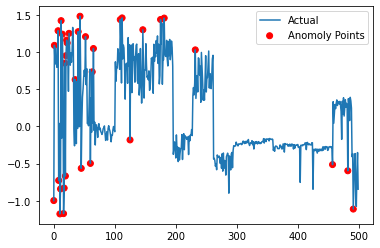

In [16]:
import scipy
import matplotlib.cm as cm
dataRange = 500
Data.test[1][0:25230,0]
linear_predicted[0:25230]
plt.plot(Data.test[1][0:dataRange,0])
#print(linear_predicted[0:25230])
anomalyList =[]
anomalyListXCoords =[]
count = 0
total=0
for x in range(dataRange):
    difference = abs(Data.test[1][x,0]-linear_predicted[x])
    total = difference + total
    count += 1
total = total / count
print(f"The Average is: {total}")
count = 0
for x in range(dataRange):
    difference = abs(Data.test[1][x,0]-linear_predicted[x])
    if difference > 3*total:
        anomalyList.append(Data.test[1][x,0])
        anomalyListXCoords.append(count)
    count += 1
percentageAnomalous =  round(len(anomalyList)/dataRange *100)
print(f"The percentage of total anomalous points was: {percentageAnomalous}%")
colors = cm.rainbow(np.linspace(1, 1, len(anomalyList)))
print(f"The len of anomalyList: {len(anomalyList)}")
#print(anomolyList)
#plt.scatter(linear_predicted[0:25230])
#print(f"The anomalyList: {anomalyList}\nThe anomalyListXCoords: {anomalyListXCoords}")

plt.scatter(anomalyListXCoords, anomalyList, c=colors)
#plt.scatter([1762, 4443, 19902, 23501, 25112], [3.7193446, 4.0872087, 4.4067316, 3.9032767, 4.3992643])#, c=colors)

plt.legend(["Actual", "Anomoly Points"])
plt.show()

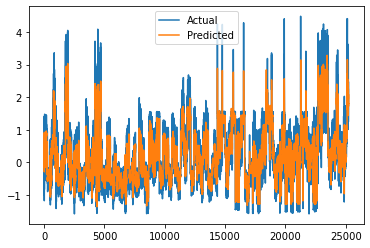

In [17]:
plt.plot(Data.test[1][0:25230,0])
plt.plot(linear_predicted[0:25230])
plt.legend(["Actual", "Predicted"])
plt.show()

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

mse = mean_squared_error(Data.test[1][:,0], linear_predicted.flatten())
rmse = sqrt(mean_squared_error(Data.test[1][:,0], linear_predicted.flatten()))
mae = mean_absolute_error(Data.test[1][:,0], linear_predicted.flatten())
rse_val = rse(Data.test[1][:,0], linear_predicted.flatten())

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'RSE: {rse_val}')

accuracy_stats['rmse']['mlp'] = rmse
accuracy_stats['rse']['mlp'] = rse_val
# accuracy_stats['corr']['mlp'] = corr
# accuracy_stats['accuracy']['mlp'] = acc
accuracy_stats['mae']['mlp'] = mae
accuracy_stats['predicted']['mlp'] = linear_predicted
accuracy_stats['mse']['mlp'] = mse

MSE: 0.11679242551326752
RMSE: 0.34174906805032773
MAE: 0.2406184822320938
RSE: 0.3819536864757538


## SIMPLE LSTM

Here we run our data through a simple lstm for comparison

In [19]:
Data.train[0][:,:,0][0]

array([ 0.05524609,  0.05917626,  0.04876131, -0.14597867, -0.03554086,
        0.15605499,  0.3653366 ,  0.09808496,  0.18454872, -0.01471096],
      dtype=float32)

In [20]:
Data.train[0][:,:,0][0]

array([ 0.05524609,  0.05917626,  0.04876131, -0.14597867, -0.03554086,
        0.15605499,  0.3653366 ,  0.09808496,  0.18454872, -0.01471096],
      dtype=float32)

In [21]:
# define lstm network

# lstm_model = tf.keras.models.Sequential([
#     # Shape [batch, time, features] => [batch, time, lstm_units]
#     tf.keras.layers.GRU(32, input_shape=(10), return_sequences=False),
#     # Shape => [batch, time, features]
#     tf.keras.layers.Dense(units=1)
# ])

ts_inputs = tf.keras.Input(shape=(10,3))
x = tf.keras.layers.LSTM(units=250, dropout=0.1, recurrent_dropout=0.1)(ts_inputs)
# x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1,activation='linear')(x)
lstm_model = tf.keras.Model(inputs=ts_inputs, outputs=outputs)

In [22]:
lstm_model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf_rse, tf_corr, tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError(), tf.metrics.RootMeanSquaredError()])

In [23]:
lstm_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 3)]           0         
                                                                 
 lstm (LSTM)                 (None, 250)               254000    
                                                                 
 dense_3 (Dense)             (None, 1)                 251       
                                                                 
Total params: 254,251
Trainable params: 254,251
Non-trainable params: 0
_________________________________________________________________


In [24]:
history = lstm_model.fit(Data.train[0][:,:,:], Data.train[1][:,0], 
               epochs=100, 
               validation_data=(Data.valid[0][:,:,:], Data.valid[1][:,0]), 
               callbacks=[early_stopping],
               shuffle=False)

Epoch 1/100
2803/2803 [==============================] - 35s 12ms/step - loss: 0.2351 - tf_rse: 1.5644 - tf_corr: 0.1526 - mean_absolute_error: 0.3563 - mean_squared_error: 0.2351 - root_mean_squared_error: 0.4849 - val_loss: 0.2404 - val_tf_rse: 1.1268 - val_tf_corr: 0.3890 - val_mean_absolute_error: 0.3487 - val_mean_squared_error: 0.2404 - val_root_mean_squared_error: 0.4903
Epoch 2/100
2803/2803 [==============================] - 34s 12ms/step - loss: 0.2228 - tf_rse: 1.3167 - tf_corr: 0.1574 - mean_absolute_error: 0.3454 - mean_squared_error: 0.2228 - root_mean_squared_error: 0.4720 - val_loss: 0.2287 - val_tf_rse: 1.0681 - val_tf_corr: 0.3799 - val_mean_absolute_error: 0.3316 - val_mean_squared_error: 0.2287 - val_root_mean_squared_error: 0.4782.2214 - root_mean_squared_error: 0
Epoch 3/100
2803/2803 [==============================] - 35s 13ms/step - loss: 0.2162 - tf_rse: 1.2724 - tf_corr: 0.1593 - mean_absolute_error: 0.3393 - mean_squared_error: 0.2162 - root_mean_squared_erro

In [25]:
lstm_stats = lstm_model.evaluate(Data.test[0][:,:,:], Data.test[1][:,0])
lstm_stats

789/789 [==============================] - 2s 3ms/step - loss: 0.1317 - tf_rse: 1.1122 - tf_corr: 0.3163 - mean_absolute_error: 0.2687 - mean_squared_error: 0.1317 - root_mean_squared_error: 0.3629


[0.13170455396175385,
 1.112210988998413,
 0.31628718972206116,
 0.2687497138977051,
 0.13170455396175385,
 0.3629112243652344]

In [26]:
lstm_predicted = lstm_model.predict(Data.test[0][:,:,:]).flatten()

np.save('predicted_results/lstm_predicted.npy', lstm_predicted)
np.savetxt('predicted_results/lstm_predicted.txt', lstm_predicted)
lstm_model.save_weights('./checkpoints/lstm_weights')

In [27]:
lstm_predicted = np.load('predicted_results/lstm_predicted.npy')*Data.normalize_std[0] + Data.normalize_mean[0]
data_true = Data.test[1][:,0]*Data.normalize_std[0] + Data.normalize_mean[0]
def mean_absolute_percentage_error(y_true, y_pred): 
  return np.mean(np.abs(y_true - y_pred) / np.abs(y_true)) * 100
lstm_mape = mean_absolute_percentage_error(data_true, lstm_predicted)
lstm_mape

93.52914690971375

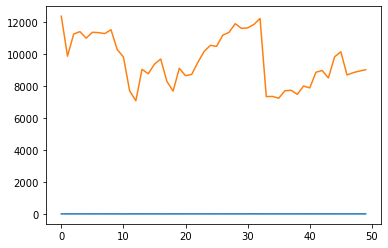

In [28]:
plt.plot(Data.test[1][0:50,0])
plt.plot(lstm_predicted[0:50])
plt.show()

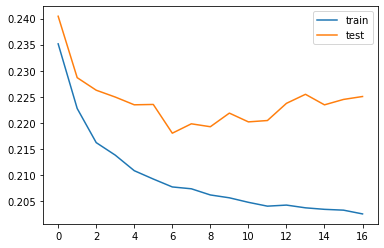

In [29]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

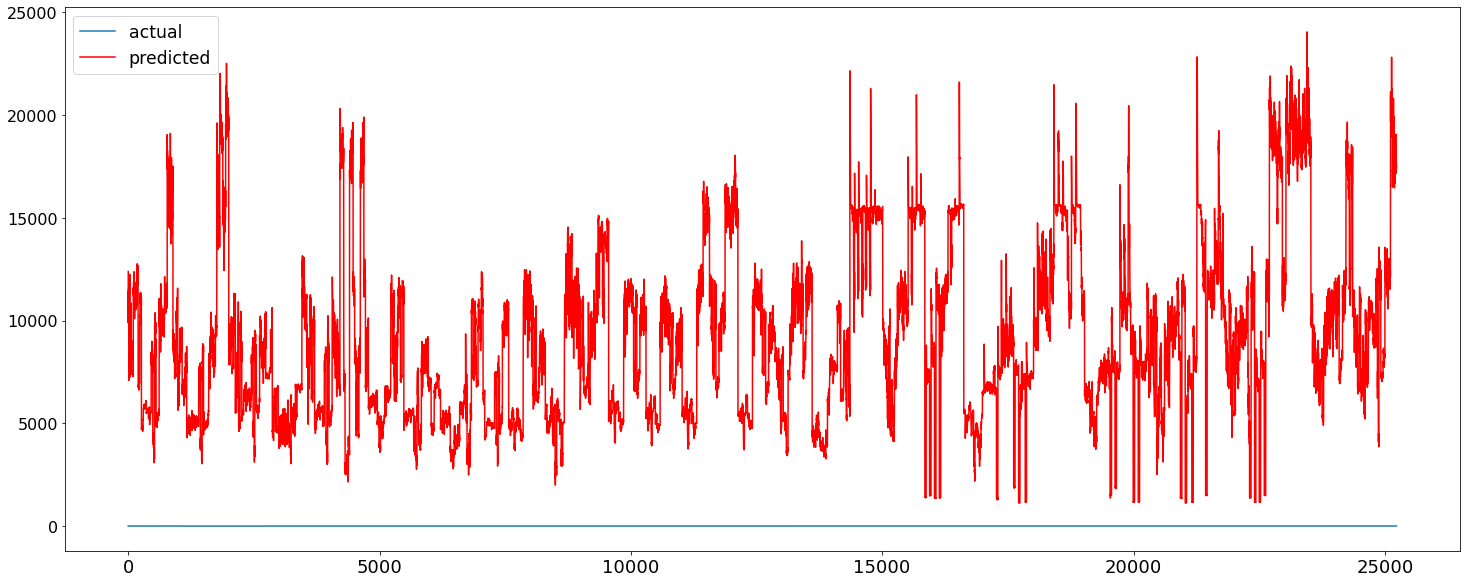

In [30]:
plt.figure(figsize=(25, 10))
plt.plot(Data.test[1][:,0],label="actual")
plt.plot(lstm_predicted, color='r',label="predicted")
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

mse = mean_squared_error(Data.test[1][:,0], lstm_predicted)
rmse = sqrt(mean_squared_error(Data.test[1][:,0], lstm_predicted))
mae = mean_absolute_error(Data.test[1][:,0], lstm_predicted)
rse_val = rse(Data.test[1][:,0], lstm_predicted)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'RSE: {rse_val}')

accuracy_stats['rmse']['lstm'] = rmse
accuracy_stats['rse']['lstm'] = rse_val
# accuracy_stats['corr']['mlp'] = corr
# accuracy_stats['accuracy']['mlp'] = acc
accuracy_stats['mae']['lstm'] = mae
accuracy_stats['predicted']['lstm'] = lstm_predicted
accuracy_stats['mse']['lstm'] = mse

MSE: 99994520.0
RMSE: 9999.725996246098
MAE: 9098.892578125
RSE: 11176.1298828125


In [32]:
lstm_predicted.shape

(25230,)

In [33]:
Data.test[1][:,0].shape

(25230,)

## Simple GRU

Do the same thing but with a GRU


In [34]:
ts_inputs = tf.keras.Input(shape=(10,3))
x = tf.keras.layers.GRU(units=250, dropout=0.1)(ts_inputs)
# x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1,activation='linear')(x)
gru_model = tf.keras.Model(inputs=ts_inputs, outputs=outputs)

In [35]:
gru_model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf_rse, tf_corr, tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError(), tf.metrics.RootMeanSquaredError()])

In [36]:
gru_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10, 3)]           0         
                                                                 
 gru (GRU)                   (None, 250)               191250    
                                                                 
 dense_4 (Dense)             (None, 1)                 251       
                                                                 
Total params: 191,501
Trainable params: 191,501
Non-trainable params: 0
_________________________________________________________________


In [ ]:
gru_model.fit(Data.train[0][:,:,:], Data.train[1][:,0], 
               epochs=100, 
               validation_data=(Data.valid[0][:,:,:], Data.valid[1][:,0]), 
               callbacks=[early_stopping],
               shuffle=True)

Epoch 1/100
2803/2803 [==============================] - 20s 7ms/step - loss: 0.2255 - tf_rse: 0.4812 - tf_corr: 0.8802 - mean_absolute_error: 0.3465 - mean_squared_error: 0.2255 - root_mean_squared_error: 0.4749 - val_loss: 0.2533 - val_tf_rse: 1.1466 - val_tf_corr: 0.3702 - val_mean_absolute_error: 0.3531 - val_mean_squared_error: 0.2533 - val_root_mean_squared_error: 0.5033
Epoch 2/100
2803/2803 [==============================] - 19s 7ms/step - loss: 0.2182 - tf_rse: 0.4740 - tf_corr: 0.8824 - mean_absolute_error: 0.3392 - mean_squared_error: 0.2182 - root_mean_squared_error: 0.4672 - val_loss: 0.2480 - val_tf_rse: 1.2116 - val_tf_corr: 0.3475 - val_mean_absolute_error: 0.3467 - val_mean_squared_error: 0.2480 - val_root_mean_squared_error: 0.4980
Epoch 3/100
2803/2803 [==============================] - 19s 7ms/step - loss: 0.2154 - tf_rse: 0.4699 - tf_corr: 0.8852 - mean_absolute_error: 0.3360 - mean_squared_error: 0.2154 - root_mean_squared_error: 0.4641 - val_loss: 0.2292 - val_tf

In [ ]:
gru_model.evaluate(Data.test[0][:,:,:], Data.test[1][:,0])

In [ ]:
gru_predicted = gru_model.predict(Data.test[0][:,:,:]).flatten()

np.save('predicted_results/gru_predicted.npy', gru_predicted)
np.savetxt('predicted_results/gru_predicted.txt', gru_predicted)
gru_model.save_weights('./checkpoints/gru_weights')

In [ ]:
gru_predicted = np.load('predicted_results/gru_predicted.npy')*Data.normalize_std[0] + Data.normalize_mean[0]
data_true = Data.test[1][:,0]*Data.normalize_std[0] + Data.normalize_mean[0]
def mean_absolute_percentage_error(y_true, y_pred): 
  return np.mean(np.abs(y_true - y_pred) / np.abs(y_true)) * 100
gru_mape = mean_absolute_percentage_error(data_true, gru_predicted)
gru_mape

In [ ]:
plt.plot(Data.test[1][0:100,0], label='actual')
plt.plot(gru_predicted[0:100], label="predicted")
plt.legend(loc='best')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

mse = mean_squared_error(Data.test[1][:,0], gru_predicted)
rmse = sqrt(mean_squared_error(Data.test[1][:,0], gru_predicted))
mae = mean_absolute_error(Data.test[1][:,0], gru_predicted)
rse_val = rse(Data.test[1][:,0], gru_predicted)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'RSE: {rse_val}')

accuracy_stats['rmse']['gru'] = rmse
accuracy_stats['rse']['gru'] = rse_val
# accuracy_stats['corr']['mlp'] = corr
# accuracy_stats['accuracy']['mlp'] = acc
accuracy_stats['mae']['gru'] = mae
accuracy_stats['predicted']['gru'] = gru_predicted
accuracy_stats['mse']['gru'] = mse

### CNN MODEL

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling1D


# cnn_model = Sequential()
# cnn_model.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(10, 3)))
# cnn_model.add(MaxPooling1D(pool_size=2))
# cnn_model.add(Flatten())
# cnn_model.add(Dense(50, activation='relu'))
# cnn_model.add(Dense(1))
# cnn_model.compile(optimizer='adam', loss='mse')

cnn_model = Sequential()
cnn_model.add(Conv1D(filters=30, kernel_size=5, activation='relu', padding='SAME', strides=1, input_shape=(10, 3)))
cnn_model.add(MaxPooling1D(pool_size=2, strides=2))
cnn_model.add(Conv1D(filters=45, kernel_size=5, activation='relu', padding='SAME', strides=1))
cnn_model.add(MaxPooling1D(pool_size=2, strides=2))
cnn_model.add(Conv1D(filters=60, kernel_size=5, activation='relu', padding='SAME', strides=1))
cnn_model.add(MaxPooling1D(pool_size=2, strides=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(120, activation='relu'))
cnn_model.add(Dense(1))
# cnn_model.compile(optimizer='adam', loss='mse')

In [ ]:
cnn_model.compile(loss=tf.losses.MeanSquaredError(),
              optimizer=tf.optimizers.Adam(),
              metrics=[tf_rse, tf_corr, tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError(), tf.metrics.RootMeanSquaredError()])

In [ ]:
cnn_model.summary()

In [ ]:
cnn_model.fit(Data.train[0][:,:,:], Data.train[1][:,0], 
               epochs=100, 
               validation_data=(Data.valid[0][:,:,:], Data.valid[1][:,0]), 
               callbacks=[early_stopping],
               shuffle=True)

In [ ]:
cnn_stats = cnn_model.evaluate(Data.test[0][:,:,:], Data.test[1][:,0])
cnn_stats

In [ ]:
cnn_predicted = cnn_model.predict(Data.test[0][:,:,:]).flatten()

np.save('predicted_results/cnn_predicted.npy', cnn_predicted)
np.savetxt('predicted_results/cnn_predicted.txt', cnn_predicted)
cnn_model.save_weights('./checkpoints/cnn_weights')

In [ ]:
plt.plot(Data.test[1][0:100,0], label='actual')
plt.plot(cnn_predicted[0:100], label="predicted")
plt.legend(loc='best')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

mse = mean_squared_error(Data.test[1][:,0], cnn_predicted)
rmse = sqrt(mean_squared_error(Data.test[1][:,0], cnn_predicted))
mae = mean_absolute_error(Data.test[1][:,0], cnn_predicted)
rse_val = rse(Data.test[1][:,0], cnn_predicted)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'RSE: {rse_val}')

accuracy_stats['rmse']['cnn'] = rmse
accuracy_stats['rse']['cnn'] = rse_val
# accuracy_stats['corr']['mlp'] = corr
# accuracy_stats['accuracy']['mlp'] = acc
accuracy_stats['mae']['cnn'] = mae
accuracy_stats['predicted']['cnn'] = cnn_predicted
accuracy_stats['mse']['cnn'] = mse

In [ ]:
cnn_predicted = np.load('predicted_results/cnn_predicted.npy')*Data.normalize_std[0] + Data.normalize_mean[0]
data_true = Data.test[1][:,0]*Data.normalize_std[0] + Data.normalize_mean[0]

cnn_mape = mean_absolute_percentage_error(data_true, cnn_predicted)
cnn_mape

### CNN-LSTM HYBRID MODEL

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, Conv2D, LSTM, MaxPooling1D

In [ ]:
cnn_lstm_model = Sequential()
cnn_lstm_model.add(Conv1D(filters=64, kernel_size=5, activation='relu', padding='SAME', strides=1, input_shape=(10, 3)))
cnn_lstm_model.add(MaxPooling1D(pool_size=2, strides=2))
cnn_lstm_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='SAME', strides=1))
cnn_lstm_model.add(MaxPooling1D(pool_size=2, strides=2))
# cnn_lstm_model.add(Conv1D(filters=10, kernel_size=3, activation='relu', padding='SAME', strides=1))
# cnn_lstm_model.add(MaxPooling1D(pool_size=2, strides=2))
# cnn_model.add(Flatten())
cnn_lstm_model.add(LSTM(32, dropout=0.1, recurrent_dropout=0.1, return_sequences=False))
cnn_lstm_model.add(Dense(100, activation='relu'))
cnn_lstm_model.add(Dense(1))

In [ ]:
cnn_lstm_model.compile(loss=tf.losses.MeanSquaredError(),
                       optimizer=tf.optimizers.Adam(),
                       metrics=[tf_rse, tf_corr, tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError(), tf.metrics.RootMeanSquaredError()])

In [ ]:
cnn_lstm_model.summary()

In [ ]:
cnn_lstm_model.fit(Data.train[0][:,:,:], Data.train[1][:,0], 
                   epochs=100, 
                   validation_data=(Data.valid[0][:,:,:], Data.valid[1][:,0]), 
                   callbacks=[early_stopping],
                   shuffle=True)

In [ ]:
cnn_lstm1_stats = cnn_lstm_model.evaluate(Data.test[0][:,:,:], Data.test[1][:,0])
cnn_lstm1_stats

In [ ]:
cnn_lstm_predicted = cnn_lstm_model.predict(Data.test[0][:,:,:]).flatten()

In [ ]:
plt.plot(Data.test[1][0:100,0], label='actual')
plt.plot(cnn_lstm_predicted[0:100], label="predicted")
plt.legend(loc='best')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

mse = mean_squared_error(Data.test[1][:,0], cnn_lstm_predicted)
rmse = sqrt(mean_squared_error(Data.test[1][:,0], cnn_lstm_predicted))
mae = mean_absolute_error(Data.test[1][:,0], cnn_lstm_predicted)
rse_val = rse(Data.test[1][:,0], cnn_lstm_predicted)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'RSE: {rse_val}')

accuracy_stats['rmse']['cnn_lstm'] = rmse
accuracy_stats['rse']['cnn_lstm'] = rse_val
# accuracy_stats['corr']['mlp'] = corr
# accuracy_stats['accuracy']['mlp'] = acc
accuracy_stats['mae']['cnn_lstm'] = mae
accuracy_stats['predicted']['cnn_lstm'] = cnn_lstm_predicted
accuracy_stats['mse']['cnn_lstm'] = mse

### Take 2

In [ ]:
Data.train[0].shape

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                patience=10,
                                                mode='min')

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, LSTM, MaxPooling2D, Reshape, TimeDistributed, Input, Dropout, GRU

In [ ]:
X = Input(shape = (10,3))


#CNN
C = Reshape((10, 3, 1))(X)

# Apply a Conv2D that will transform it into data of dimensions (batchsize, time, 1, NumofFilters)
C = Conv2D(filters=200, kernel_size=(1, 3), kernel_initializer='glorot_uniform')(C)
C = Dropout(0.2)(C)

# Adjust data dimensions by removing axis=2 which is always equal to 1
c_shape = K.int_shape(C)
C = Reshape((c_shape[1], c_shape[3]))(C)

# Apply a GRU layer (with activation set to 'relu' as per the paper) and take the returned states as result
_, R = GRU(200, activation="relu", return_sequences = False, return_state = True)(C)
R    = Dropout(0.2)(R)
Y = Flatten()(R)
Y = Dense(3)(Y)
cnn_lstm_model2 = Model(inputs = X, outputs = Y)

In [ ]:
cnn_lstm_model2.compile(loss=tf.losses.MeanSquaredError(),
                       optimizer=tf.optimizers.Adam(),
                       metrics=[tf_rse, tf_corr, tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError(), tf.metrics.RootMeanSquaredError()])

In [ ]:
cnn_lstm_model2.summary()

In [ ]:
# tf.random.set_seed(123456)
cnn_lstm_model2.fit(Data.train[0][:,:,:], Data.train[1][:,0], 
                   epochs=10, 
                   validation_data=(Data.valid[0][:,:,:], Data.valid[1]), 
                   callbacks=[early_stopping],
                   shuffle=True)

In [ ]:
cnn_lstm_model2.evaluate(Data.test[0][:,:,:], Data.test[1])

In [ ]:
cnn_lstm_model2_predicted

In [ ]:
cnn_lstm_model2_predicted = cnn_lstm_model2.predict(Data.test[0][:,:,:])

np.save('predicted_results/cnn_lstm_predicted.npy', cnn_lstm_model2_predicted)
np.savetxt('predicted_results/cnn_lstm_predicted.txt', cnn_lstm_model2_predicted)
cnn_lstm_model.save_weights('./checkpoints/cnn_lstm_weights')

In [ ]:
plt.plot(Data.test[1][0:100,0], label='actual')
plt.plot(cnn_lstm_model2_predicted[0:100,0], label="predicted")
plt.legend(loc='best')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

mse = mean_squared_error(Data.test[1][:,0], cnn_lstm_model2_predicted.flatten())
rmse = sqrt(mean_squared_error(Data.test[1][:,0], cnn_lstm_model2_predicted.flatten()))
mae = mean_absolute_error(Data.test[1][:,0], cnn_lstm_model2_predicted.flatten())
rse_val = rse(Data.test[1][:,0], cnn_lstm_model2_predicted[:,0].flatten())

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'RSE: {rse_val}')

accuracy_stats['rmse']['cnn_lstm2'] = rmse
accuracy_stats['rse']['cnn_lstm2'] = rse_val
# accuracy_stats['corr']['mlp'] = corr
# accuracy_stats['accuracy']['mlp'] = acc
accuracy_stats['mae']['cnn_lstm2'] = mae
accuracy_stats['predicted']['cnn_lstm2'] = cnn_lstm_model2_predicted
accuracy_stats['mse']['cnn_lstm2'] = mse

### LSTNET MODEL

In [ ]:
from tensorflow.keras.models import Model, model_from_json

custom_objects = {
        'PreSkipTrans': PreSkipTrans,
        'PostSkipTrans': PostSkipTrans,
        'PreARTrans': PreARTrans,
        'PostARTrans': PostARTrans
        }


def custom_loss(y_true, y_pred):
    # print("CUSTOM LOSS BABBBY")
    # print(type(y_true))
    # print(type(y_pred))
    # print(y_true)
    # print(y_true.shape)
    # tf.print(y_true[:,0, sys.stdout)
    return tf.keras.losses.mean_absolute_error(y_true[:,0], y_pred[:,0])

file = 'models/model2.json'
lstnet_model = None
with open(file, "r") as json_file:
  lstnet_model = model_from_json(json_file.read(), custom_objects=custom_objects)


In [ ]:
lstnet_model.compile(loss=custom_loss,
                       optimizer=tf.optimizers.Adam(),
                       metrics=[single_rse, single_corr, tf_rse, tf_corr, tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError(), tf.metrics.RootMeanSquaredError()])

In [ ]:
lstnet_model.fit(Data.train[0][:,:,:], Data.train[1][:,0], 
                   epochs=20, 
                   validation_data=(Data.valid[0][:,:,:], Data.valid[1][:,0]), 
                   callbacks=[early_stopping],
                   shuffle=True,
                   batch_size=91)

In [ ]:
lstnet_model.summary()

In [ ]:
lstnet_model.evaluate(Data.test[0], Data.test[1])

In [ ]:
lstnet_predicted = lstnet_model.predict(Data.test[0])

np.save('predicted_results/lstnet_predicted.npy', lstnet_predicted)
np.savetxt('predicted_results/lstnet_predicted.txt', lstnet_predicted)
lstnet_model.save_weights('./checkpoints/lstnet_weights')

In [ ]:
plt.plot(Data.test[1][0:100,0], label='actual')
plt.plot(lstnet_predicted[0:100, 0], label="predicted")
plt.legend(loc='best')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
print(f'MSE: {mean_squared_error(Data.test[1][:,0], lstnet_predicted[:,0])}')
print(f'RMSE: {sqrt(mean_squared_error(Data.test[1][:,0], lstnet_predicted[:,0]))}')
print(f'MAE: {mean_absolute_error(Data.test[1][:,0], lstnet_predicted[:,0])}')
print(f'RSE: {rse(Data.test[1][:,0], lstnet_predicted[:,0])}')

In [ ]:
Data.test[1][:,0]

In [ ]:
lstnet_predicted[:,0]

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
  return np.mean(np.abs(y_true - y_pred) / np.abs(y_true)) * 100

In [ ]:
mean_absolute_percentage_error(Data.test[1][:,0]*Data.normalize_std[0] + Data.normalize_mean[0], lstnet_predicted[:,0]*Data.normalize_std[0] + Data.normalize_mean[0])

# Comparison between Different Methods

In [ ]:
mlp_predicted = np.load('predicted_results/mlp_predicted.npy')*Data.normalize_std[0] + Data.normalize_mean[0]
lstm_predicted = np.load('predicted_results/lstm_predicted.npy')*Data.normalize_std[0] + Data.normalize_mean[0]
gru_predicted = np.load('predicted_results/gru_predicted.npy')*Data.normalize_std[0] + Data.normalize_mean[0]
cnn_predicted = np.load('predicted_results/cnn_predicted.npy')*Data.normalize_std[0] + Data.normalize_mean[0]
cnn_lstm_predicted = np.load('predicted_results/cnn_lstm_predicted.npy')*Data.normalize_std[0] + Data.normalize_mean[0]
lstnet_predicted = np.load('predicted_results/lstnet_predicted.npy')*Data.normalize_std[0] + Data.normalize_mean[0]

data_true = Data.test[1][:,0]*Data.normalize_std[0] + Data.normalize_mean[0]

In [ ]:
data_true.shape

In [ ]:
from cycler import cycler

# Create cycler object. Use any styling from above you please
monochrome = (cycler('color', ['k']) * cycler('linestyle', ['-', '--', ':']) * cycler('marker', ['^',',', '.']))

# Print examples of output from cycler object. 
# A cycler object, when called, returns a `iter.cycle` object that iterates over items indefinitely

default_cycler = (cycler(color=['black', 'r', 'b', 'y', 'teal', 'green', 'purple']) +
                  cycler(linestyle=['-', '--', ':', '-.', '-.', '-', '--']))

In [ ]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

cmap_1 = ListedColormap(["darkorange", "gold", "lawngreen", "lightseagreen"])

In [ ]:
start_time = 150
end_time = 200
plt.rcParams["figure.figsize"] = (10,7)
# plt.rc('axes', prop_cycle=default_cycler)
# plt.style.use('grayscale')
plt.plot(data_true[start_time:end_time], label='actual')
plt.plot(mlp_predicted[start_time:end_time, 0], label="mlp")
plt.plot(lstm_predicted[start_time:end_time], label="lstm")
plt.plot(gru_predicted[start_time:end_time], label="gru")
plt.plot(cnn_predicted[start_time:end_time], label="cnn")
plt.plot(cnn_lstm_predicted[start_time:end_time, 0], label="cnn+gru")
plt.plot(lstnet_predicted[start_time:end_time, 0], label="lstnet")
plt.ylabel('Throughput (Mbits/sec)')
plt.xlabel('Day')
plt.legend(loc='best')
plt.show()

### RMSE

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [ ]:
mlp_rmse = sqrt(mean_squared_error(data_true, mlp_predicted[:, 0]))
mlp_rmse

In [ ]:
lstm_rmse = sqrt(mean_squared_error(data_true, lstm_predicted))
lstm_rmse

In [ ]:
gru_rmse = sqrt(mean_squared_error(data_true, gru_predicted))
gru_rmse

In [ ]:
cnn_rmse = sqrt(mean_squared_error(data_true, cnn_predicted))
cnn_rmse

In [ ]:
cnn_lstm_rmse = sqrt(mean_squared_error(data_true, cnn_lstm_predicted[:, 0]))
cnn_lstm_rmse

In [ ]:
lstnet_rmse = sqrt(mean_squared_error(data_true, lstnet_predicted[:, 0]))
lstnet_rmse

In [ ]:
fig = plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.bar(x=['ARIMA', 'MLP', 'LSTM', 'GRU', 'CNN', 'CNN+LSTM', 'LSTNet'], 
        height=[0.45, mlp_rmse, lstm_rmse, gru_rmse, cnn_rmse, cnn_lstm_rmse, lstnet_rmse])
ax.set_xlabel('Model')

ax.set_ylabel('Root Mean Squared Error (RMSE)')

### MAPE

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
  return np.mean(np.abs(y_true - y_pred) / np.abs(y_true)) * 100

In [ ]:
mlp_mape = mean_absolute_percentage_error(data_true, mlp_predicted[:, 0])
mlp_mape

In [ ]:
lstm_mape = mean_absolute_percentage_error(data_true, lstm_predicted)
lstm_mape

In [ ]:
gru_mape = mean_absolute_percentage_error(data_true, gru_predicted)
gru_mape

In [ ]:
cnn_mape = mean_absolute_percentage_error(data_true, cnn_predicted)
cnn_mape

In [ ]:
cnn_lstm_mape = mean_absolute_percentage_error(data_true, cnn_lstm_predicted[:, 0])
cnn_lstm_mape

In [ ]:
lstnet_mape = mean_absolute_percentage_error(data_true, lstnet_predicted[:, 0])
lstnet_mape

In [ ]:
fig = plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.bar(x=['ARIMA', 'MLP', 'LSTM', 'GRU', 'CNN', 'CNN+LSTM', 'LSTNet'], 
        height=[79, mlp_mape, lstm_mape, gru_mape, cnn_mape, cnn_lstm_mape, lstnet_mape])
ax.set_xlabel('Model')
# ax.set_ylim(0.0, 0.9)
ax.set_ylabel('Mean Absolute Percentage Error (MAPE) %')

### CORR

In [ ]:
mlp_corr = corr(data_true, mlp_predicted[:, 0])
mlp_corr

In [ ]:
lstm_corr = corr(data_true, lstm_predicted)
lstm_corr

In [ ]:
gru_corr = corr(data_true, gru_predicted)
gru_corr

In [ ]:
cnn_corr = corr(data_true, cnn_predicted)
cnn_corr

In [ ]:
cnn_lstm_corr = corr(data_true, cnn_lstm_predicted[:, 0])
cnn_lstm_corr

In [ ]:
lstnet_corr = corr(data_true, lstnet_predicted[:, 0])
lstnet_corr

In [ ]:
import scipy
scipy.stats.pearsonr(data_true, lstnet_predicted[:, 0])

In [ ]:
fig = plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.bar(x=['ARIMA', 'MLP', 'LSTM', 'GRU', 'CNN', 'CNN+LSTM', 'LSTNet'], 
        height=[0.88, mlp_corr, lstm_corr, gru_corr, cnn_corr, cnn_lstm_corr, lstnet_corr])
ax.set_xlabel('Model')
ax.set_ylim(0.85, 0.95)
ax.set_ylabel('Mean Absolute Percentage Error (MAPE) %')

### r2

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
mlp_r2 = r2_score(data_true, mlp_predicted[:, 0])
lstm_r2 = r2_score(data_true, lstm_predicted)
gru_r2 = r2_score(data_true, gru_predicted)
cnn_r2 = r2_score(data_true, cnn_predicted)
cnn_lstm_r2 = r2_score(data_true, cnn_lstm_predicted[:, 0])
lstnet_r2 = r2_score(data_true, lstnet_predicted[:, 0])


In [ ]:
print(f'mlp r2:     {mlp_r2}')
print(f'lstm r2:    {lstm_r2}')
print(f'gru r2:     {gru_r2}')
print(f'cnn r2:     {cnn_r2}')
print(f'cnn+gru r2: {cnn_lstm_r2}')
print(f'lstnet r2:  {lstnet_r2}')


### RRSE

In [ ]:
mlp_rrse = rse(data_true, mlp_predicted[:, 0])
mlp_rrse

In [ ]:
lstm_rrse = rse(data_true, lstm_predicted)
lstm_rrse

In [ ]:
gru_rrse = rse(data_true, gru_predicted)
gru_rrse

In [ ]:
cnn_rrse = rse(data_true, cnn_predicted)
cnn_rrse

In [ ]:
cnn_lstm_rrse = rse(data_true, cnn_lstm_predicted[:, 0].flatten())
cnn_lstm_rrse

In [ ]:
lstnet_rrse = rse(data_true, lstnet_predicted[:, 0].flatten())
lstnet_rrse

In [ ]:
fig = plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.bar(x=['ARIMA', 'MLP', 'LSTM', 'GRU', 'CNN', 'CNN+LSTM', 'LSTNet'], 
        height=[0.79, mlp_rrse,lstm_rrse,gru_rrse,cnn_rrse,cnn_lstm_rrse,lstnet_rrse])
ax.set_xlabel('Model')
# ax.set_ylim(0.0, 0.9)
ax.set_ylabel('Root Relative Squared Error (RRSE)')

### MAE

In [ ]:
from sklearn.metrics import mean_absolute_error

In [ ]:
mlp_mae = mean_absolute_error(data_true, mlp_predicted[:, 0])
mlp_mae

In [ ]:
lstm_mae = mean_absolute_error(data_true, lstm_predicted)
lstm_mae

In [ ]:
gru_mae = mean_absolute_error(data_true, gru_predicted)
gru_mae

In [ ]:
cnn_mae = mean_absolute_error(data_true, cnn_predicted)
cnn_mae

In [ ]:
cnn_lstm_mae = mean_absolute_error(data_true, cnn_lstm_predicted[:, 0])
cnn_lstm_mae

In [ ]:
lstnet_mae = mean_absolute_error(data_true, lstnet_predicted[:, 0])
lstnet_mae

In [ ]:
fig = plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.bar(x=['ARIMA', 'MLP', 'LSTM', 'GRU', 'CNN', 'CNN+LSTM', 'LSTNet'], 
        height=[79, mlp_mae, lstm_mae, gru_mae, cnn_mae, cnn_lstm_mae, lstnet_mae])
ax.set_xlabel('Model')
# ax.set_ylim(0.0, 0.9)
ax.set_ylabel('Mean Absolute Percentage Error (MAPE) %')

### RMSRE (root mean square relative error)

In [ ]:
from sklearn.metrics import mean_absolute_error

In [ ]:
mlp_mae = mean_absolute_error(data_true, mlp_predicted[:, 0])
mlp_mae

In [ ]:
lstm_mae = mean_absolute_error(data_true, lstm_predicted)
lstm_mae

In [ ]:
gru_mae = mean_absolute_error(data_true, gru_predicted)
gru_mae

In [ ]:
cnn_mae = mean_absolute_error(data_true, cnn_predicted)
cnn_mae

In [ ]:
cnn_lstm_mae = mean_absolute_error(data_true, cnn_lstm_predicted[:, 0])
cnn_lstm_mae

In [ ]:
lstnet_mae = mean_absolute_error(data_true, lstnet_predicted[:, 0])
lstnet_mae

In [ ]:
fig = plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.bar(x=['ARIMA', 'MLP', 'LSTM', 'GRU', 'CNN', 'CNN+LSTM', 'LSTNet'], 
        height=[79, mlp_mae, lstm_mae, gru_mae, cnn_mae, cnn_lstm_mae, lstnet_mae])
ax.set_xlabel('Model')
# ax.set_ylim(0.0, 0.9)
ax.set_ylabel('Mean Absolute Percentage Error (MAPE) %')

### CDF of Relative Error

In [ ]:
mlp_relative_error = (data_true - mlp_predicted[:, 0]) / data_true
lstm_relative_error = (data_true - lstm_predicted) / data_true

In [ ]:
mlp_residual_error = (data_true - mlp_predicted[:, 0])

In [ ]:
mlp_relative_error

In [ ]:
plt.plot(mlp_relative_error)

In [ ]:
num_bins = 40
counts, bin_edges = np.histogram (abs(mlp_relative_error), bins=num_bins, normed=True)
cdf = np.cumsum (counts)
plt.plot (bin_edges[1:], cdf/cdf[-1])
counts, bin_edges = np.histogram (abs(lstm_relative_error), bins=num_bins, normed=True)
cdf = np.cumsum (counts)
plt.plot (bin_edges[1:], cdf/cdf[-1])

## ARIMA

In [ ]:
arima_actual = np.load('predicted_results/arima_data_actual_multivar_1.npy')
arima_predicted = np.load('predicted_results/arima_data_predictions_multivar_1.npy')

In [ ]:
arima_actual.shape

In [ ]:
arima_predicted.shape

In [ ]:
plt.plot(arima_actual[0:300])
plt.plot(arima_predicted[0:300])

In [ ]:
arima_rrse = rse(arima_actual, arima_predicted)
arima_rrse

In [ ]:
from sklearn.metrics import mean_absolute_error
arima_mae = mean_absolute_error(arima_actual, arima_predicted)
arima_mae

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
  return np.mean(np.abs(y_true - y_pred) / np.abs(y_true)) * 100

arima_mape = mean_absolute_percentage_error(arima_actual, arima_predicted)
arima_mape

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

arima_rmse = sqrt(mean_squared_error(arima_actual, arima_predicted))
arima_rmse

In [ ]:
arima_corr = corr(arima_actual, arima_predicted)
arima_corr

# Prediction for all models on a single route (from test dataset)

In [ ]:
test_sample = np.load('numpy_group_test_data/1_stream_test_sample_group_95.npy')
test_target = np.load('numpy_group_test_data/1_stream_test_target_group_95.npy')

normalize_mean = 9726.925995055048
normalize_std  = 6670.752950995383


In [ ]:
test_target[:,0]

In [ ]:
import statsmodels.api as sm 

arma_mod = sm.tsa.ARIMA(test_target[:,0], order=(8,0,8))
arma_res = arma_mod.fit(trend='nc', disp=-1)
arma_predictions = arma_res.predict()

In [ ]:
arma_predictions

### Load weights for models

In [ ]:
# Create a new model instance

# Restore the weights
linear.load_weights('./checkpoints/linear_weights')


In [ ]:
linear_test_predict = linear.predict(test_sample)
lstm_test_predict = lstm_model.predict(test_sample)
gru_test_predict = gru_model.predict(test_sample)
cnn_test_predict = cnn_model.predict(test_sample)
cnn_lstm_test_predict = cnn_lstm_model.predict(test_sample)
lstnet_test_predict = lstnet_model.predict(test_sample)

In [ ]:
plt.rcParams["figure.figsize"] = (10,7)
plt.plot(test_target[1:,0] * normalize_std + normalize_mean, label='actual')
plt.plot(arma_predictions[1:] * normalize_std + normalize_mean, label='arima')
plt.plot(linear_test_predict[1:] * normalize_std + normalize_mean, label='mlp')
plt.plot(lstm_test_predict[1:] * normalize_std + normalize_mean, label='lstm')
plt.plot(gru_test_predict[1:] * normalize_std + normalize_mean, label='gru')
plt.plot(cnn_test_predict[1:] * normalize_std + normalize_mean, label='cnn')
plt.plot(cnn_lstm_test_predict[1:,0] * normalize_std + normalize_mean, label='cnn+gru')
plt.plot(lstnet_test_predict[1:,0] * normalize_std + normalize_mean, label='lstnet')
plt.ylabel('Throughput (Mbits/sec)')
plt.xlabel('Day')
plt.legend(loc='best')

In [ ]:
mean_absolute_percentage_error(test_target[1:,0],)